In [1]:
pip install -r https://raw.githubusercontent.com/rizki96/ds_challenge/master/requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import io
import bz2
import pandas as pd
import numpy as np
import geohash
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from shapely.geometry import MultiPoint
from geopy.distance import great_circle
from pandas.plotting import register_matplotlib_converters
from collections import OrderedDict
from itertools import islice

register_matplotlib_converters()

In [3]:
# from local data file
#trf_df = pd.read_csv('training.csv.bz2', compression='bz2', header=0, sep=',', quotechar='"')
#trf_df_sort = trf_df.sort_values(by=['day', 'timestamp'])

# from remote data file
url="https://github.com/rizki96/ds_challenge/blob/master/Traffic%20Management/training.csv.bz2?raw=true"
s=requests.get(url).content
data = bz2.decompress(s)
trf_df = pd.read_csv(io.BytesIO(data), header=0, sep=',', quotechar='"')
trf_df_sort = trf_df.sort_values(by=['day', 'timestamp'])

In [4]:
trf_df_sort[:5]

,geohash6,day,timestamp,demand
2289,qp09sx,1,0:0,0.021212
3149,qp0dhg,1,0:0,0.013217
11052,qp03x5,1,0:0,0.157956
23011,qp09bw,1,0:0,0.001262
26180,qp03wn,1,0:0,0.032721


In [5]:
trf_df_sort["dts_cal"] = [datetime.datetime.strptime('2019-03-31 00:00:00.00', '%Y-%m-%d %H:%M:%S.%f') + datetime.timedelta(days=day, hours=int(timestamp.split(":")[0]), minutes=int(timestamp.split(":")[1])) for day,timestamp in trf_df_sort[["day", "timestamp"]].values]

In [6]:
trf_df_sort[:5]

,geohash6,day,timestamp,demand,dts_cal
2289,qp09sx,1,0:0,0.021212,2019-04-01
3149,qp0dhg,1,0:0,0.013217,2019-04-01
11052,qp03x5,1,0:0,0.157956,2019-04-01
23011,qp09bw,1,0:0,0.001262,2019-04-01
26180,qp03wn,1,0:0,0.032721,2019-04-01


# data point population count

In [7]:
dt_count = {dtstamp[0]: 0 for dtstamp in trf_df_sort[['day']].values}

In [8]:
for dtstamp in trf_df_sort[['day']].values:
    dt_count[dtstamp[0]] += 1

In [9]:
dt_count = [(d, dt_count[d]) for d in dt_count]
ts, points = zip(*dt_count)
dt_frame = pd.DataFrame({'ts': ts, 'pcounts': points})
dt_frame[:5]

,ts,pcounts
0,1,67627
1,2,70452
2,3,69966
3,4,72609
4,5,67279


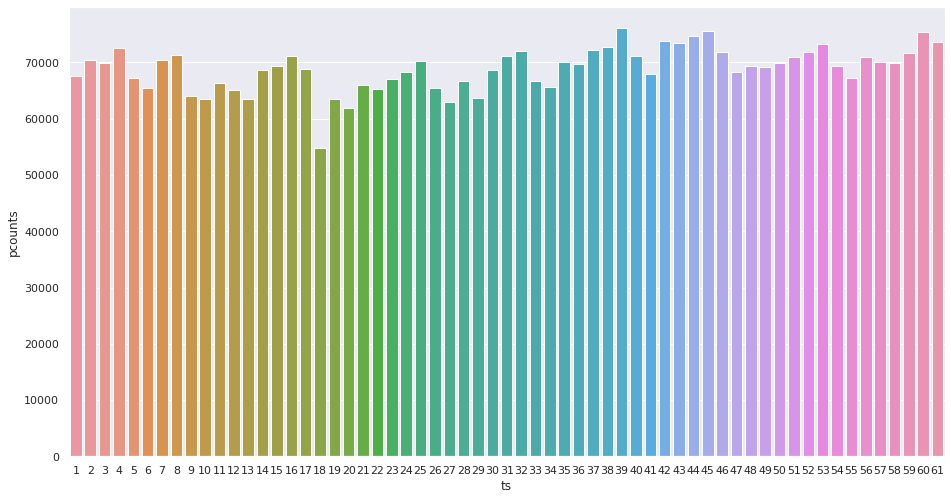

In [10]:
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.barplot(data=dt_frame, x='ts', y='pcounts')
plt.show()

# average demand per day

In [11]:
avg_demand_day = trf_df_sort.groupby(['day'])['demand'].apply(lambda x: np.mean(x))
dt_frame['avg_demand_day'] = [a for a in avg_demand_day]
dt_frame[:5]

,ts,pcounts,avg_demand_day
0,1,67627,0.093651
1,2,70452,0.109683
2,3,69966,0.108904
3,4,72609,0.120707
4,5,67279,0.094623


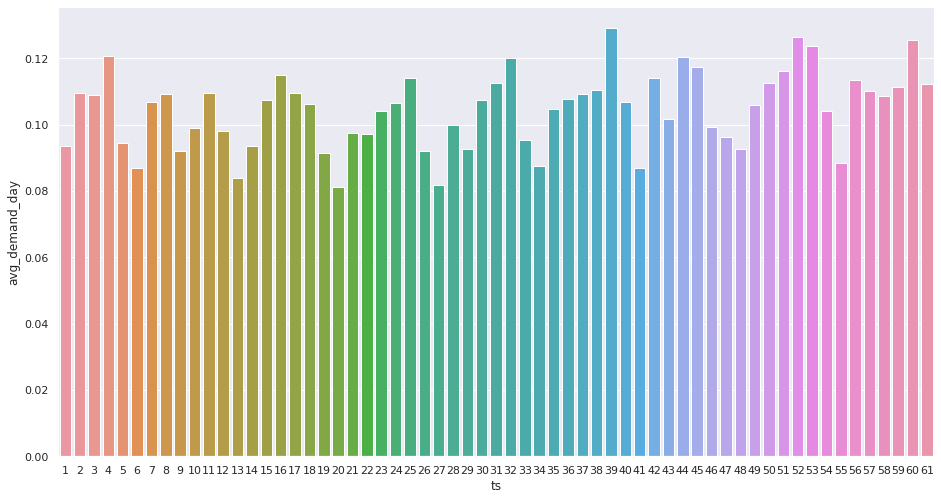

In [12]:
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.barplot(data=dt_frame, x='ts', y='avg_demand_day')
plt.show()

# convert geohash into latitude longitude

In [13]:
trf_df_sort.loc[:, 'latlon'] = trf_df_sort.geohash6.map(lambda x: geohash.decode(x))
trf_df_sort['lat'] = [ll[0][0] for ll in trf_df_sort[['latlon']].values]
trf_df_sort['lon'] = [ll[0][1] for ll in trf_df_sort[['latlon']].values]

In [14]:
trf_df_sort[:5]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon
2289,qp09sx,1,0:0,0.021212,2019-04-01,"(-5.32012939453125, 90.9063720703125)",-5.320129,90.906372
3149,qp0dhg,1,0:0,0.013217,2019-04-01,"(-5.25421142578125, 90.9173583984375)",-5.254211,90.917358
11052,qp03x5,1,0:0,0.157956,2019-04-01,"(-5.34210205078125, 90.6646728515625)",-5.342102,90.664673
23011,qp09bw,1,0:0,0.001262,2019-04-01,"(-5.28167724609375, 90.7305908203125)",-5.281677,90.730591
26180,qp03wn,1,0:0,0.032721,2019-04-01,"(-5.32562255859375, 90.6207275390625)",-5.325623,90.620728


# week 1 data

In [15]:
num_of_days = 7
area_covered = 1 # in km
min_samples = 1
trf_week1 = pd.DataFrame(trf_df_sort[(trf_df_sort.day > 0) & (trf_df_sort.day <= num_of_days)])

In [16]:
trf_week1[:5]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon
2289,qp09sx,1,0:0,0.021212,2019-04-01,"(-5.32012939453125, 90.9063720703125)",-5.320129,90.906372
3149,qp0dhg,1,0:0,0.013217,2019-04-01,"(-5.25421142578125, 90.9173583984375)",-5.254211,90.917358
11052,qp03x5,1,0:0,0.157956,2019-04-01,"(-5.34210205078125, 90.6646728515625)",-5.342102,90.664673
23011,qp09bw,1,0:0,0.001262,2019-04-01,"(-5.28167724609375, 90.7305908203125)",-5.281677,90.730591
26180,qp03wn,1,0:0,0.032721,2019-04-01,"(-5.32562255859375, 90.6207275390625)",-5.325623,90.620728


# day 1 cluster

In [17]:
trf_day1 = pd.DataFrame(trf_week1[trf_week1.day == 1])
coords = trf_day1[['lat', 'lon']].values

In [18]:
kms_per_radian = 6371.0088
epsilon = area_covered / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=min_samples, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
# mark as -1 for outliers
clusters = pd.Series([coords[cluster_labels == n] for n in range(-1, num_clusters) if coords[cluster_labels == n].any()])
#clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters) if coords[cluster_labels == n].any()])
#num_clusters = len(clusters)
print('Number of day 1 clusters: {}'.format(num_clusters))
clusters

Number of day 1 clusters: 115


0      [[-5.32012939453125, 90.9063720703125], [-5.35...
1      [[-5.25421142578125, 90.9173583984375], [-5.25...
2      [[-5.34210205078125, 90.6646728515625], [-5.29...
3      [[-5.28167724609375, 90.7305908203125], [-5.28...
4      [[-5.32562255859375, 90.6207275390625], [-5.35...
5      [[-5.40252685546875, 90.8184814453125], [-5.28...
6      [[-5.40252685546875, 90.6427001953125], [-5.40...
7      [[-5.29266357421875, 90.8624267578125], [-5.38...
8      [[-5.33111572265625, 90.6866455078125], [-5.39...
9      [[-5.29266357421875, 90.8514404296875], [-5.27...
10     [[-5.31463623046875, 90.6536865234375], [-5.27...
11     [[-5.32562255859375, 90.6976318359375], [-5.38...
12     [[-5.35308837890625, 90.7745361328125], [-5.36...
13     [[-5.39154052734375, 90.7086181640625], [-5.28...
14     [[-5.28717041015625, 90.8953857421875], [-5.34...
15     [[-5.32562255859375, 90.5987548828125], [-5.35...
16     [[-5.32012939453125, 90.7855224609375], [-5.32...
17     [[-5.34759521484375, 90.

# cluster centermost_points

In [19]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = clusters.map(get_centermost_point)
centermost_points

0      (-5.32562255859375, 90.9063720703125)
1      (-5.24871826171875, 90.9173583984375)
2      (-5.33660888671875, 90.6646728515625)
3      (-5.28167724609375, 90.7305908203125)
4      (-5.35858154296875, 90.6207275390625)
5      (-5.33660888671875, 90.8184814453125)
6      (-5.39703369140625, 90.6427001953125)
7      (-5.35858154296875, 90.8624267578125)
8      (-5.36956787109375, 90.6866455078125)
9      (-5.34210205078125, 90.8514404296875)
10     (-5.33660888671875, 90.6536865234375)
11     (-5.36407470703125, 90.6976318359375)
12     (-5.33111572265625, 90.7745361328125)
13     (-5.34759521484375, 90.7086181640625)
14     (-5.30914306640625, 90.8953857421875)
15     (-5.36956787109375, 90.5987548828125)
16     (-5.35308837890625, 90.7855224609375)
17     (-5.37506103515625, 90.5877685546875)
18     (-5.31463623046875, 90.6427001953125)
19     (-5.36407470703125, 90.6097412109375)
20     (-5.35308837890625, 90.6756591796875)
21     (-5.40252685546875, 90.8734130859375)
22     (-5

In [20]:
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})

In [21]:
rs = rep_points.apply(lambda row: trf_day1[(trf_day1['lat']==row['lat']) & (trf_day1['lon']==row['lon'])].iloc[0], axis=1)
rs[-5:]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon
110,qp09jc,1,9:0,0.003892,2019-04-01 09:00:00,"(-5.44097900390625, 90.9613037109375)",-5.440979,90.961304
111,qp08g6,1,4:45,0.004255,2019-04-01 04:45:00,"(-5.47943115234375, 90.8514404296875)",-5.479431,90.851440
112,qp093j,1,8:45,0.006363,2019-04-01 08:45:00,"(-5.37506103515625, 90.7525634765625)",-5.375061,90.752563
113,qp09vc,1,9:0,0.001620,2019-04-01 09:00:00,"(-5.30914306640625, 90.9613037109375)",-5.309143,90.961304
114,qp09n4,1,9:30,0.001705,2019-04-01 09:30:00,"(-5.43548583984375, 90.9722900390625)",-5.435486,90.972290


# cluster member and centermost_point visualization

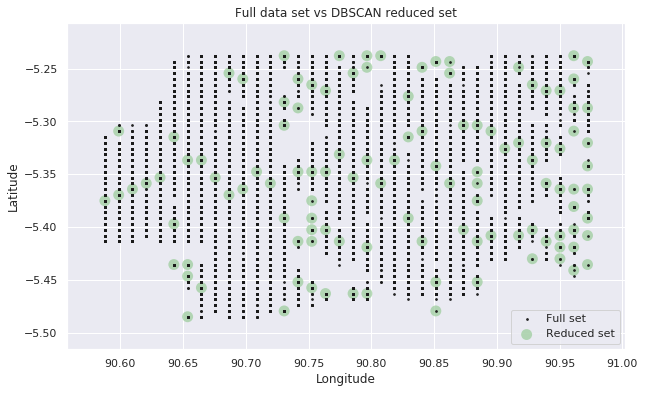

In [22]:
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['lon'], rs['lat'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(trf_day1['lon'], trf_day1['lat'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='lower right')
plt.show()

# set label and is_centroid to cluster

In [23]:
# cluster_labels
trf_day1['cluster_ids'] = cluster_labels

In [24]:
trf_day1[:5]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids
2289,qp09sx,1,0:0,0.021212,2019-04-01,"(-5.32012939453125, 90.9063720703125)",-5.320129,90.906372,0
3149,qp0dhg,1,0:0,0.013217,2019-04-01,"(-5.25421142578125, 90.9173583984375)",-5.254211,90.917358,1
11052,qp03x5,1,0:0,0.157956,2019-04-01,"(-5.34210205078125, 90.6646728515625)",-5.342102,90.664673,2
23011,qp09bw,1,0:0,0.001262,2019-04-01,"(-5.28167724609375, 90.7305908203125)",-5.281677,90.730591,3
26180,qp03wn,1,0:0,0.032721,2019-04-01,"(-5.32562255859375, 90.6207275390625)",-5.325623,90.620728,4


In [25]:
trf_day1 = trf_day1.sort_values(by=['cluster_ids', 'dts_cal', 'demand'])
trf_day1['is_centroid'] = [(rs['geohash6'][y] == x) for x,y in trf_day1[['geohash6', 'cluster_ids']].values]

In [26]:
trf_day1[-5:]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids,is_centroid
1188906,qp09jc,1,9:0,0.003892,2019-04-01 09:00:00,"(-5.44097900390625, 90.9613037109375)",-5.440979,90.961304,110,True
2323508,qp08g6,1,4:45,0.004255,2019-04-01 04:45:00,"(-5.47943115234375, 90.8514404296875)",-5.479431,90.851440,111,True
2313365,qp093j,1,8:45,0.006363,2019-04-01 08:45:00,"(-5.37506103515625, 90.7525634765625)",-5.375061,90.752563,112,True
1874532,qp09vc,1,9:0,0.001620,2019-04-01 09:00:00,"(-5.30914306640625, 90.9613037109375)",-5.309143,90.961304,113,True
1795605,qp09n4,1,9:30,0.001705,2019-04-01 09:30:00,"(-5.43548583984375, 90.9722900390625)",-5.435486,90.972290,114,True


# set highest_demand and average demand to cluster

In [27]:
trf_day1_avg_demand = trf_day1.groupby(['cluster_ids','geohash6'])['demand'].apply(lambda x: np.mean(x)).sort_values(ascending=False)
trf_day1['highest_demand'] = [trf_day1_avg_demand[x].index[0] == y for x,y in trf_day1[['cluster_ids', 'geohash6']].values]
trf_day1['avg_demand'] = [trf_day1_avg_demand[x][y] for x,y in trf_day1[['cluster_ids', 'geohash6']].values]

In [28]:
#trf_day1[(trf_day1.highest_demand == True) & (trf_day1.geohash6 == 'qp09jt')][:5]
trf_day1[(trf_day1.highest_demand == True)][-5:]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids,is_centroid,highest_demand,avg_demand
4061012,qp09jb,1,4:30,0.017670,2019-04-01 04:30:00,"(-5.44647216796875, 90.9613037109375)",-5.446472,90.961304,110,False,True,0.017670
2323508,qp08g6,1,4:45,0.004255,2019-04-01 04:45:00,"(-5.47943115234375, 90.8514404296875)",-5.479431,90.851440,111,True,True,0.004255
2313365,qp093j,1,8:45,0.006363,2019-04-01 08:45:00,"(-5.37506103515625, 90.7525634765625)",-5.375061,90.752563,112,True,True,0.006363
1874532,qp09vc,1,9:0,0.001620,2019-04-01 09:00:00,"(-5.30914306640625, 90.9613037109375)",-5.309143,90.961304,113,True,True,0.001620
1795605,qp09n4,1,9:30,0.001705,2019-04-01 09:30:00,"(-5.43548583984375, 90.9722900390625)",-5.435486,90.972290,114,True,True,0.001705


# visualize time, center point and highest demand

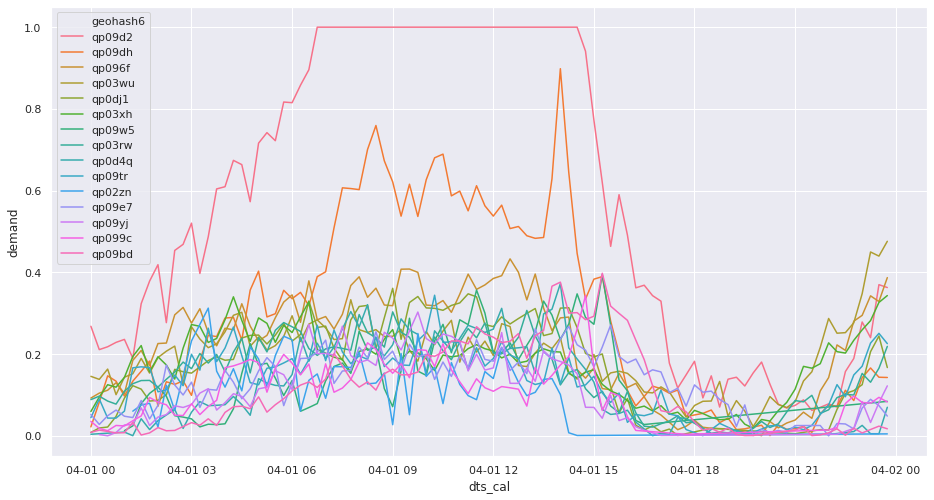

In [29]:
# observation 15 samples cluster's center point demand
trf_day1_center = pd.DataFrame(trf_day1[(trf_day1.is_centroid == True)].sort_values(by=['avg_demand', 'cluster_ids'], ascending=False))
top_clusters = list(OrderedDict.fromkeys([c[0] for c in trf_day1_center[['cluster_ids']].values]))[0:15]
top_trf_day1_center = trf_day1_center[(trf_day1_center.cluster_ids.isin(top_clusters))]
#trf_day1_cl0_others = pd.DataFrame(trf_day1[(trf_day1.is_centroid == False) & (trf_day1.cluster_ids == 0) & (trf_day1.demand > 0.0)])
#ax = sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=trf_day1_cl0_others, legend="full")
#for l in ax.lines:
#    l.set_linestyle("--")
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=top_trf_day1_center, legend="full")
plt.show()

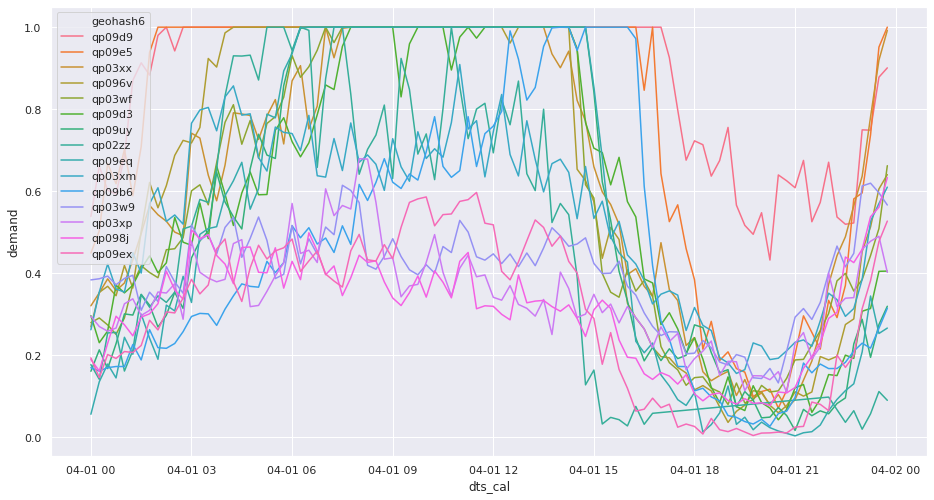

In [30]:
# observation 15 samples cluster's highest demand
trf_day1_highest = pd.DataFrame(trf_day1[(trf_day1.highest_demand == True)].sort_values(by=['avg_demand', 'cluster_ids'], ascending=False))
top_clusters = list(OrderedDict.fromkeys([c[0] for c in trf_day1_highest[['cluster_ids']].values]))[0:15]
top_trf_day1_highest = trf_day1_highest[(trf_day1_highest.cluster_ids.isin(top_clusters))]
#trf_week1_cl0_lower = pd.DataFrame(trf_week1[(trf_week1.highest_demand == False) & (trf_week1.cluster_ids == 0) & (trf_week1.demand > 0.0)])
#ax = sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=trf_week1_cl0_lower, legend="full")
#for l in ax.lines:
#    l.set_linestyle("--")
#    plt.setp(l,linewidth=1)
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=top_trf_day1_highest, legend="full")
plt.show()

# zero filling timeseries gap for cluster's highest demand

In [31]:
# looking for anomaly, is there any duplicate timeseries data (make sure it's unique)
unique = True
for c in list(OrderedDict.fromkeys([c[0] for c in trf_day1_highest[['cluster_ids']].values])):
    if not pd.Series(y for x,y in trf_day1_highest[['cluster_ids', 'dts_cal']].values if x == c).is_unique:
        print('timeseries cluster %s is not unique' % (c,))
        unique = False
if unique:
    print('all timeseries clusters are unique')

all timeseries clusters are unique


In [32]:
# reinitial dataframe, fill unset timestamp with zero
multiplier = 1
trf_day1_complete = pd.DataFrame({'geohash6': [],
                                   'day': [],
                                   'timestamp': [],
                                   'demand': [],
                                   'dts_cal': [],
                                   'latlon': [],
                                   'lat': [], 'lon': [],
                                   'cluster_ids': [],
                                   'is_centroid': [],
                                   'highest_demand': [],
                                   'avg_demand': []})
interval_time = [datetime.timedelta(days=(int(t/(24*4)) + 1),minutes=15*t) for t in range(24*4*multiplier)]
start_date = datetime.datetime.strptime('2019-03-31 00:00:00.00', '%Y-%m-%d %H:%M:%S.%f')
gh = trf_day1_highest.groupby(['cluster_ids'])['geohash6'].apply(list)
demand = trf_day1_highest.groupby(['cluster_ids', 'dts_cal'])['demand'].apply(list)
avg_demand = trf_day1_highest.groupby(['cluster_ids'])['avg_demand'].apply(list)
highest_demand = trf_day1_highest.groupby(['cluster_ids'])['highest_demand'].apply(list)
is_centroid = trf_day1_highest.groupby(['cluster_ids'])['is_centroid'].apply(list)
cluster_list = list(OrderedDict.fromkeys([c[0] for c in trf_day1_highest[['cluster_ids']].values]))

trf_day1_complete['cluster_ids'] = [c for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['geohash6'] = [gh[c][0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['dts_cal'] = [(start_date + t) for t in interval_time for c in cluster_list]
trf_day1_complete['day'] = [int(t/(24*4)) + 1 for t in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['timestamp'] = ['%s:%s' % ((start_date + t).hour, (start_date + t).minute) for t in interval_time for c in cluster_list]
trf_day1_complete['avg_demand'] = [avg_demand[c][0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['highest_demand'] = [highest_demand[c][0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['is_centroid'] = [is_centroid[c][0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['demand'] = [demand[c][start_date + t][0] if (start_date + t) in demand[c] else 0 for t in interval_time for c in cluster_list]
trf_day1_complete['latlon'] = [geohash.decode(gh[c][0]) for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['lat'] = [geohash.decode(gh[c][0])[0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['lon'] = [geohash.decode(gh[c][0])[1] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete


,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids,is_centroid,highest_demand,avg_demand
0,qp09d9,1,0:0,0.538371,2019-04-01 00:00:00,"(-5.35308837890625, 90.8184814453125)",-5.353088,90.818481,5,False,True,0.878146
1,qp09e5,1,0:0,0.449159,2019-04-01 00:00:00,"(-5.34210205078125, 90.8404541015625)",-5.342102,90.840454,41,False,True,0.782948
2,qp03xx,1,0:0,0.320478,2019-04-01 00:00:00,"(-5.32012939453125, 90.6866455078125)",-5.320129,90.686646,8,False,True,0.639723
3,qp096v,1,0:0,0.269423,2019-04-01 00:00:00,"(-5.37506103515625, 90.8294677734375)",-5.375061,90.829468,29,False,True,0.634337
4,qp03wf,1,0:0,0.279437,2019-04-01 00:00:00,"(-5.34759521484375, 90.6536865234375)",-5.347595,90.653687,10,False,True,0.600956
5,qp09d3,1,0:0,0.296414,2019-04-01 00:00:00,"(-5.35308837890625, 90.8074951171875)",-5.353088,90.807495,31,False,True,0.574970
6,qp09uy,1,0:0,0.160733,2019-04-01 00:00:00,"(-5.28167724609375, 90.9173583984375)",-5.281677,90.917358,27,False,True,0.562404
7,qp02zz,1,0:0,0.176994,2019-04-01 00:00:00,"(-5.45196533203125, 90.6976318359375)",-5.451965,90.697632,11,False,True,0.548984
8,qp09eq,1,0:0,0.055975,2019-04-01 00:00:00,"(-5.32562255859375, 90.8514404296875)",-5.325623,90.851440,9,False,True,0.542357
9,qp03xm,1,0:0,0.261962,2019-04-01 00:00:00,"(-5.33111572265625, 90.6756591796875)",-5.331116,90.675659,20,False,True,0.537501


# visualize after zero fill gap

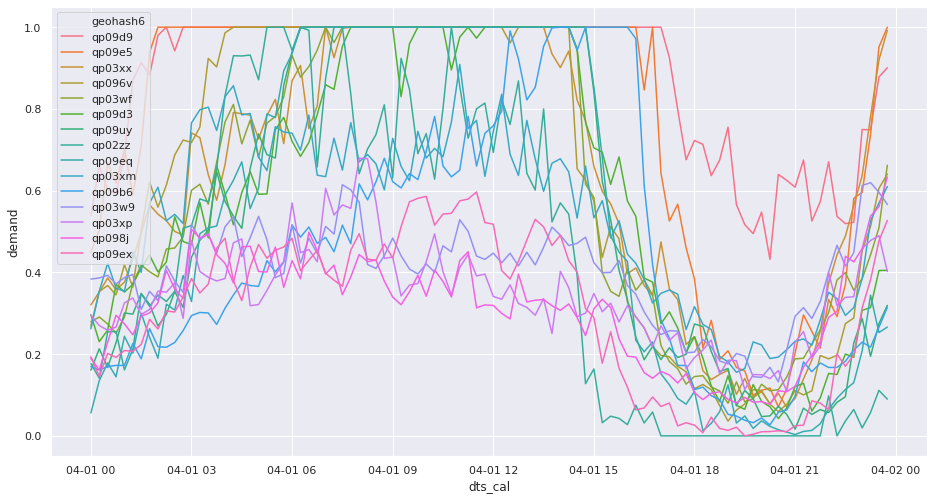

In [33]:
# recognize 15 samples cluster's highest demand
top_clusters = list(OrderedDict.fromkeys([c[0] for c in trf_day1_complete[['cluster_ids']].values]))[0:15]
top_trf_day1_complete_highest = trf_day1_complete[(trf_day1_complete.cluster_ids.isin(top_clusters))]
#trf_week1_cl0_lower = pd.DataFrame(trf_week1[(trf_week1.highest_demand == False) & (trf_week1.cluster_ids == 0) & (trf_week1.demand > 0.0)])
#ax = sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=trf_week1_cl0_lower, legend="full")
#for l in ax.lines:
#    l.set_linestyle("--")
#    plt.setp(l,linewidth=1)
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=top_trf_day1_complete_highest, legend="full")
plt.show()

# timeseries prediction

In [34]:
# prepare sorted data
total_sequence_series = 24*4 # 15 minutes within 24 hours
prediction_length = int(0.25*total_sequence_series)
trf_day1_complete_sort = trf_day1_complete.sort_values(by=['cluster_ids','dts_cal'], ascending=True)
trf_day1_complete_sort[:5]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids,is_centroid,highest_demand,avg_demand
16,qp09s8,1,0:0,0.039257,2019-04-01 00:00:00,"(-5.35858154296875, 90.9063720703125)",-5.358582,90.906372,0,False,True,0.289362
131,qp09s8,1,0:15,0.051022,2019-04-01 00:15:00,"(-5.35858154296875, 90.9063720703125)",-5.358582,90.906372,0,False,True,0.289362
246,qp09s8,1,0:30,0.000086,2019-04-01 00:30:00,"(-5.35858154296875, 90.9063720703125)",-5.358582,90.906372,0,False,True,0.289362
361,qp09s8,1,0:45,0.046106,2019-04-01 00:45:00,"(-5.35858154296875, 90.9063720703125)",-5.358582,90.906372,0,False,True,0.289362
476,qp09s8,1,1:0,0.047315,2019-04-01 01:00:00,"(-5.35858154296875, 90.9063720703125)",-5.358582,90.906372,0,False,True,0.289362


In [35]:
# splitting data training and testing
start = pd.Timestamp("2019-04-01 00:00:00", freq="15M")
start_date = datetime.datetime.strptime('2019-03-31 00:00:00.00', '%Y-%m-%d %H:%M:%S.%f')
interval_time = [datetime.timedelta(days=(int(t/(24*4)) + 1),minutes=15*t) for t in range(24*4*multiplier)]
cluster_list = list(set([c for c in trf_day1_complete_sort['cluster_ids']]))
demand = trf_day1_complete_sort.groupby(['cluster_ids', 'dts_cal'])['demand'].apply(list)

train_day1_ds = [[demand[c][start_date + t][0] for t in interval_time[:-prediction_length]] for c in cluster_list]
# train dataset: use only 75% dataset, add "target" and "start" fields
train_ds = [{'target': x, 'start': start} for x in train_day1_ds]

test_day1_ds = [[demand[c][start_date + t][0] for t in interval_time] for c in cluster_list]
# test dataset: use the whole day1 dataset, add "target" and "start" fields
test_ds = [{'target': x, 'start': start} for x in test_day1_ds]


In [36]:
def plot_forecasts(tss, forecasts, past_length, num_plots):
    for target, forecast in islice(zip(tss, forecasts), num_plots):
        ax = target[-past_length:].plot(figsize=(12,5), linewidth=2)
        forecast.plot(color='g')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        plt.show()

INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:02<00:00, 18.36it/s, avg_epoch_loss=-2.19]
INFO:root:Epoch[0] Elapsed time 2.725 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=-2.193565
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 16.24it/s, avg_epoch_loss=-2.67]
INFO:root:Epoch[1] Elapsed time 3.080 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=-2.672800
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:02<00:00, 17.71it/s, avg_epoch_loss=-2.67]
INFO:root:Epoch[2] Elapsed time 2.828 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=-2.668322
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:02<00:00, 18.72it/s, avg_epoch_loss=-2.72]
INFO:root:Epoch[3] Elapsed time 2.673 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-2.720397
INFO:root:Epoch[4] Learning rate i

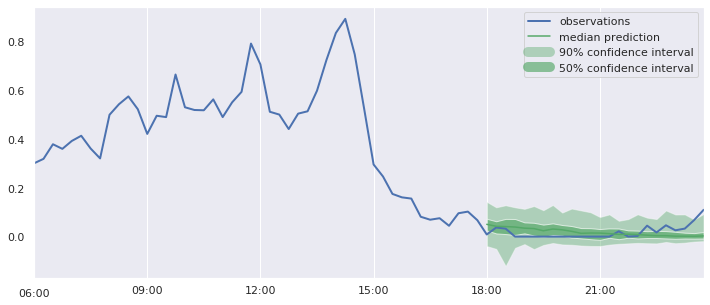

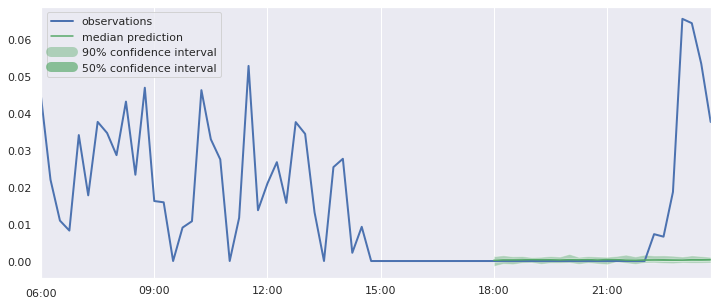

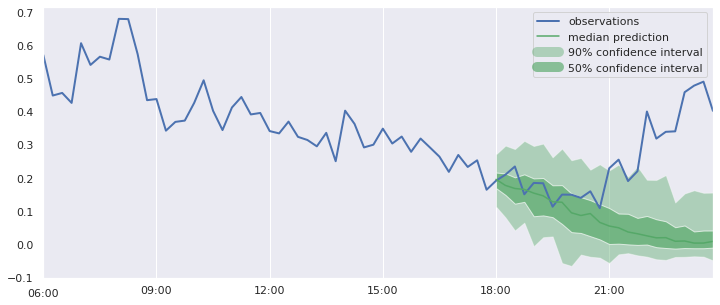

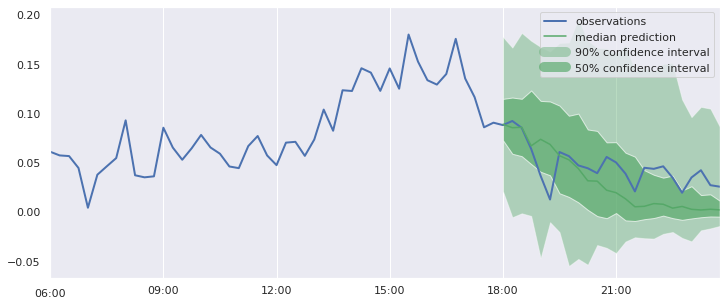

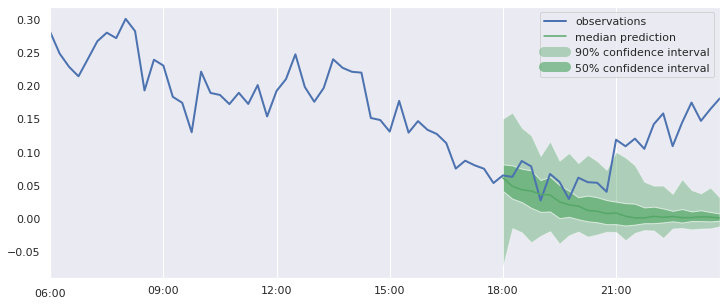

In [37]:
# start training, predicting and evaluating
# TODO: fine tuning the parameters
import pprint
from gluonts.dataset import common
from gluonts.model import deepar
from gluonts.model import simple_feedforward
from gluonts.trainer import Trainer
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions

train_data = common.ListDataset(train_ds, freq="15min")
test_data = common.ListDataset(test_ds, freq="15min")
estimator = deepar.DeepAREstimator(
    freq="15min", 
    prediction_length=prediction_length,
    trainer=Trainer(epochs=10)
)
#estimator = simple_feedforward.SimpleFeedForwardEstimator(
#    freq="15min",
#    prediction_length=prediction_length,
#    trainer=Trainer(epochs=100, num_batches_per_epoch=50)
#)
predictor = estimator.train(train_data)

forecast_it, ts_it = make_evaluation_predictions(
    test_data, predictor=predictor, num_eval_samples=100
)

# First 5 clusters (0,1,2,3,4,5)
# TODO: plot for highest demand
forecasts = list(forecast_it)[:5]
tss = list(ts_it)[:5]
plot_forecasts(tss, forecasts, past_length=total_sequence_series-prediction_length,num_plots=5)

#agg_metrics, item_metrics = Evaluator()(
#    ts_it, forecast_it, num_series=len(test_data)
#)

#pprint.pprint(agg_metrics)

#prediction = next(predictor.predict(data))
#print(prediction)
#prediction.plot(output_file="graph.png")


# day 2 cluster

In [38]:
trf_day2 = pd.DataFrame(trf_week1[trf_week1.day == 2])
coords = trf_day2[['lat', 'lon']].values

In [39]:
kms_per_radian = 6371.0088
epsilon = area_covered / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=min_samples, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
# mark as -1 for outliers
clusters = pd.Series([coords[cluster_labels == n] for n in range(-1, num_clusters) if coords[cluster_labels == n].any()])
#clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters) if coords[cluster_labels == n].any()])
#num_clusters = len(clusters)
print('Number of day 2 clusters: {}'.format(num_clusters))

Number of day 2 clusters: 97


In [40]:
centermost_points = clusters.map(get_centermost_point)

In [41]:
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})

In [42]:
rs = rep_points.apply(lambda row: trf_day2[(trf_day2['lat']==row['lat']) & (trf_day2['lon']==row['lon'])].iloc[0], axis=1)
rs[-5:]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon
92,qp0d5e,2,13:0,0.005861,2019-04-02 13:00:00,"(-5.25421142578125, 90.8624267578125)",-5.254211,90.862427
93,qp09bv,2,2:45,0.004240,2019-04-02 02:45:00,"(-5.28717041015625, 90.7415771484375)",-5.287170,90.741577
94,qp03nf,2,5:0,0.043754,2019-04-02 05:00:00,"(-5.43548583984375, 90.6536865234375)",-5.435486,90.653687
95,qp09np,2,6:30,0.005978,2019-04-02 06:30:00,"(-5.40802001953125, 90.9722900390625)",-5.408020,90.972290
96,qp09tu,2,7:30,0.015484,2019-04-02 07:30:00,"(-5.33660888671875, 90.9613037109375)",-5.336609,90.961304


In [43]:
# cluster_labels
trf_day2['cluster_ids'] = cluster_labels

In [44]:
trf_day2[-5:]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids
4199944,qp094j,2,9:45,0.004501,2019-04-02 09:45:00,"(-5.41900634765625, 90.7965087890625)",-5.419006,90.796509,36
4200500,qp09gy,2,9:45,0.121835,2019-04-02 09:45:00,"(-5.28167724609375, 90.8734130859375)",-5.281677,90.873413,50
4201116,qp09b6,2,9:45,0.652544,2019-04-02 09:45:00,"(-5.30364990234375, 90.7196044921875)",-5.303650,90.719604,9
4205826,qp09b5,2,9:45,0.092578,2019-04-02 09:45:00,"(-5.29815673828125, 90.7086181640625)",-5.298157,90.708618,3
4206017,qp090p,2,9:45,0.042690,2019-04-02 09:45:00,"(-5.40802001953125, 90.7086181640625)",-5.408020,90.708618,3


In [45]:
trf_day2 = trf_day2.sort_values(by=['cluster_ids', 'dts_cal', 'demand'])
trf_day2['is_centroid'] = [(rs['geohash6'][y] == x) for x,y in trf_day2[['geohash6', 'cluster_ids']].values]

In [46]:
trf_day2_avg_demand = trf_day2.groupby(['cluster_ids','geohash6'])['demand'].apply(lambda x: np.mean(x)).sort_values(ascending=False)
trf_day2['highest_demand'] = [trf_day2_avg_demand[x].index[0] == y for x,y in trf_day2[['cluster_ids', 'geohash6']].values]
trf_day2['avg_demand'] = [trf_day2_avg_demand[x][y] for x,y in trf_day2[['cluster_ids', 'geohash6']].values]

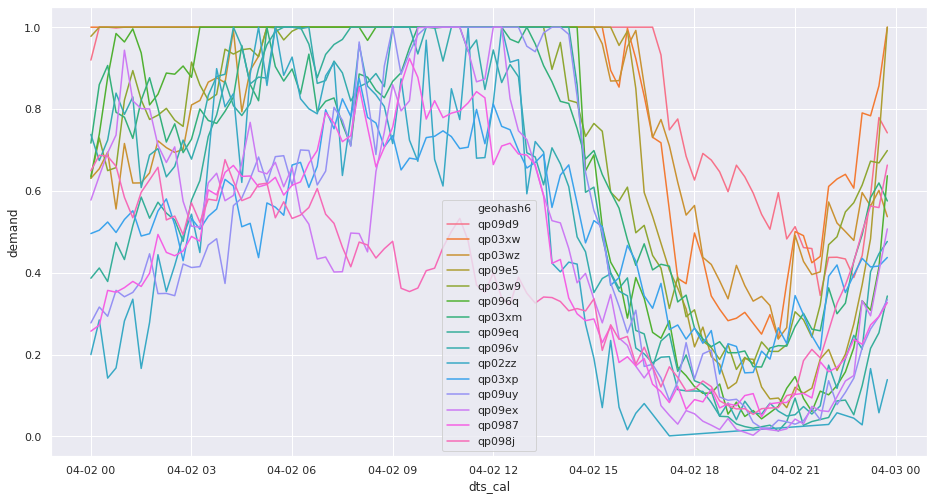

In [47]:
# recognize 15 samples cluster's highest demand
trf_day2_highest = pd.DataFrame(trf_day2[(trf_day2.highest_demand == True)].sort_values(by=['avg_demand', 'cluster_ids'], ascending=False))
top_clusters = list(OrderedDict.fromkeys([c[0] for c in trf_day2_highest[['cluster_ids']].values]))[0:15]
top_trf_day2_highest = trf_day2_highest[(trf_day2_highest.cluster_ids.isin(top_clusters))]
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=top_trf_day2_highest, legend="full")
plt.show()